In [69]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [70]:
train_path = '/content/FLIR_groups1and2_train.csv'
test_path = '/content/FLIR_groups1and2_test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Dataset Cleaning - Train

In [71]:
train_data.head(3)

Unnamed: 0  Unnamed: 1    Round 1: Unnamed: 3 Unnamed: 4   Unnamed: 5  \
0        NaN         NaN         NaN    T_CRmax    T_CLmax        T̅_CR   
1  SubjectID         NaN  T_offset_1  Max1R13_1  Max1L13_1  aveAllR13_1   
2   161117-1         NaN        0.58      34.98      35.36        34.44   

    Unnamed: 6 Unnamed: 7  Unnamed: 8  Unnamed: 9  ... Unnamed: 112  \
0        T̅_CL        NaN         NaN         NaN  ...       T_Mmax   
1  aveAllL13_1     T_RC_1  T_RC_Dry_1  T_RC_Wet_1  ...   T_OR_Max_4   
2        34.85      34.91       34.91        34.6  ...        36.39   

  Unnamed: 113 Other parameters: Unnamed: 115 Unnamed: 116 Unnamed: 117  \
0          NaN               NaN          NaN          NaN          NaN   
1          NaN            Gender          Age    Ethnicity        T_atm   
2          NaN              Male        41-50        White           24   

  Unnamed: 118 Unnamed: 119 Unnamed: 120   Target:  
0          NaN          NaN          NaN       NaN  
1     Humidity     Distance          NaN  aveOralM  
2           28          0.8          NaN     36.59  

[3 rows x 122 columns]

In [72]:
null_counts = train_data.isnull().sum()

columns_to_drop = null_counts[null_counts == len(train_data)].index
data = train_data.drop(columns=columns_to_drop)

In [73]:
columns = data.columns.tolist()
constant_features = columns[-7:]

In [74]:
constant_feature_start_index = len(columns) - 7
first_constant_feature = data.columns[0]

round_indices = {f"Round {i+1}": None for i in range(4)}
final = pd.DataFrame()
for col in columns[1:]:
    for round_name in round_indices.keys():
        if round_name in col and round_indices[round_name] is None:
            round_indices[round_name] = columns.index(col)
            break

round_dfs_t = {}
for i in range(1, 5):
    round_name = f"Round {i}"
    if i < 4:
        next_round_start = round_indices[f"Round {i+1}"]
    else:
        next_round_start = constant_feature_start_index
    round_columns = columns[round_indices[round_name]:next_round_start]

    round_dfs_t[round_name] = data[round_columns]


In [75]:
for round_name, df_round in round_dfs_t.items():
    df_round = df_round.iloc[1:].reset_index(drop=True)
    new_header = df_round.iloc[0]
    df_round = df_round[1:]
    df_round.columns = new_header
    df_round.reset_index(drop=True, inplace=True)
    round_dfs_t[round_name] = df_round

In [76]:
first = data[first_constant_feature].iloc[2:].reset_index(drop=True)
new_header = data[first_constant_feature].iloc[1]
first.columns = new_header
first.reset_index(drop=True, inplace=True)

In [77]:
last = data[columns[-7:]].iloc[2:].reset_index(drop=True)
new_header = data[columns[-7:]].iloc[1]
last.columns = new_header
last.reset_index(drop=True, inplace=True)

In [78]:
dfs = list(round_dfs_t.values())
appended_df = pd.concat(dfs, axis=1)
final = pd.concat([first, appended_df, last], axis=1)
train_df = final.rename(columns={'Unnamed: 0': 'SubjectID'})

In [79]:
from sklearn.impute import KNNImputer
import pandas as pd

exclude = ['SubjectID', 'Gender', 'Ethnicity', 'Age']
df_to_exclude = train_df[exclude]
df_to_impute = train_df.drop(exclude, axis=1)

imputer = KNNImputer(n_neighbors=5)
imputer.fit(df_to_impute)
imputed_data = imputer.transform(df_to_impute)
df_imputed = pd.DataFrame(imputed_data, columns=df_to_impute.columns)

train_df = pd.concat([df_to_exclude, df_imputed], axis=1)

In [80]:
train_df.shape

(710, 116)

# Dataset Cleaning - Test

In [81]:
test_data.head(3)

Unnamed: 0  Unnamed: 1    Round 1: Unnamed: 3 Unnamed: 4   Unnamed: 5  \
0        NaN         NaN         NaN    T_CRmax    T_CLmax        T̅_CR   
1  SubjectID         NaN  T_offset_1  Max1R13_1  Max1L13_1  aveAllR13_1   
2  180208-10         NaN           1      35.62      35.39        35.33   

    Unnamed: 6 Unnamed: 7  Unnamed: 8  Unnamed: 9  ... Unnamed: 112  \
0        T̅_CL        NaN         NaN         NaN  ...       T_Mmax   
1  aveAllL13_1     T_RC_1  T_RC_Dry_1  T_RC_Wet_1  ...   T_OR_Max_4   
2        35.07      35.59       35.59       35.44  ...        36.62   

  Unnamed: 113 Other parameters: Unnamed: 115 Unnamed: 116 Unnamed: 117  \
0          NaN               NaN          NaN          NaN          NaN   
1          NaN            Gender          Age    Ethnicity        T_atm   
2          NaN            Female        18-20        Asian           22   

  Unnamed: 118 Unnamed: 119 Unnamed: 120   Target:  
0          NaN          NaN          NaN       NaN  
1     Humidity     Distance          NaN  aveOralM  
2           30          0.6          NaN     36.74  

[3 rows x 122 columns]

In [82]:
null_counts = test_data.isnull().sum()

columns_to_drop = null_counts[null_counts == len(test_data)].index
data = test_data.drop(columns=columns_to_drop)

In [83]:
columns = data.columns.tolist()
constant_features = columns[-7:]

In [84]:
constant_feature_start_index = len(columns) - 7
first_constant_feature = data.columns[0]

round_indices = {f"Round {i+1}": None for i in range(4)}
final = pd.DataFrame()
for col in columns[1:]:
    for round_name in round_indices.keys():
        if round_name in col and round_indices[round_name] is None:
            round_indices[round_name] = columns.index(col)
            break

round_dfs = {}
for i in range(1, 5):
    round_name = f"Round {i}"
    if i < 4:
        next_round_start = round_indices[f"Round {i+1}"]
    else:
        next_round_start = constant_feature_start_index
    round_columns = columns[round_indices[round_name]:next_round_start]

    round_dfs[round_name] = data[round_columns]


In [85]:
for round_name, df_round in round_dfs.items():
    df_round = df_round.iloc[1:].reset_index(drop=True)
    new_header = df_round.iloc[0]
    df_round = df_round[1:]
    df_round.columns = new_header
    df_round.reset_index(drop=True, inplace=True)
    round_dfs[round_name] = df_round

In [86]:
first = data[first_constant_feature].iloc[2:].reset_index(drop=True)
new_header = data[first_constant_feature].iloc[1]
first.columns = new_header
first.reset_index(drop=True, inplace=True)

In [87]:
last = data[columns[-7:]].iloc[2:].reset_index(drop=True)
new_header = data[columns[-7:]].iloc[1]
last.columns = new_header
last.reset_index(drop=True, inplace=True)

In [88]:
dfs = list(round_dfs.values())
appended_df = pd.concat(dfs, axis=1)
final = pd.concat([first, appended_df, last], axis=1)
test_df = final.rename(columns={'Unnamed: 0': 'SubjectID'})

In [89]:
from sklearn.impute import KNNImputer
import pandas as pd

exclude = ['SubjectID', 'Gender', 'Ethnicity', 'Age']
df_to_exclude = test_df[exclude]
df_to_impute = test_df.drop(exclude, axis=1)

imputer = KNNImputer(n_neighbors=5)
imputer.fit(df_to_impute)
imputed_data = imputer.transform(df_to_impute)
df_imputed = pd.DataFrame(imputed_data, columns=df_to_impute.columns)

test_df = pd.concat([df_to_exclude, df_imputed], axis=1)

In [90]:
test_df.shape

(310, 116)

# Data Visualization

In [91]:
train_df.shape

(710, 116)

In [92]:
test_df.shape

(310, 116)

In [93]:
print("Null values in Train: ", train_df.isnull().sum().sum())
print("Null values in Test: ", test_df.isnull().sum().sum())

Null values in Train:  0
Null values in Test:  0


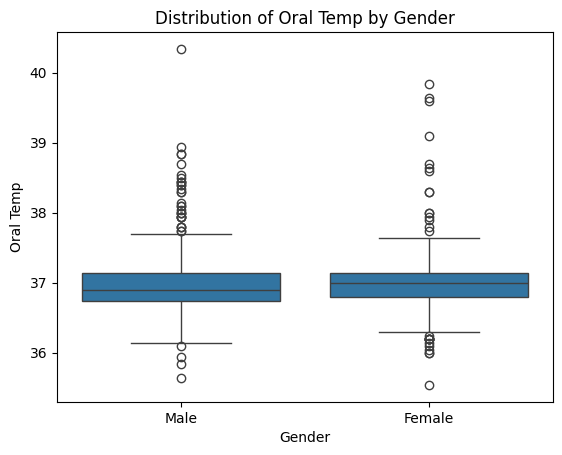

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Gender', y='aveOralM', data=train_df)
plt.title('Distribution of Oral Temp by Gender')
plt.xlabel('Gender')
plt.ylabel('Oral Temp')

plt.show()

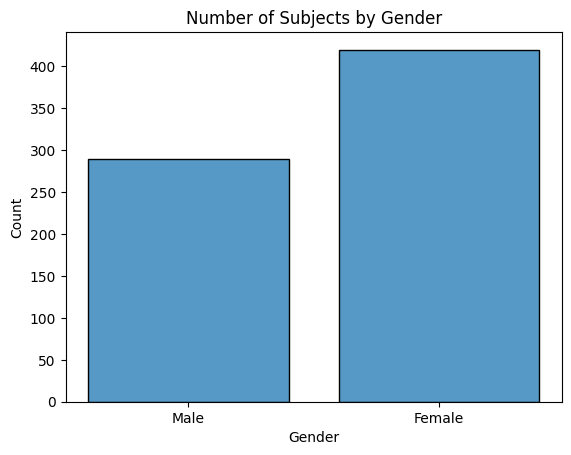

In [95]:
sns.histplot(data=train_df, x='Gender', discrete=True, shrink=0.8)
plt.title('Number of Subjects by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

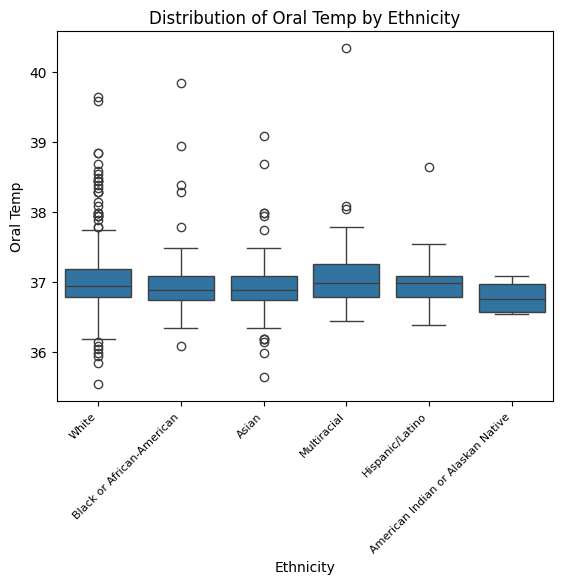

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Ethnicity', y='aveOralM', data=train_df)
plt.title('Distribution of Oral Temp by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Oral Temp')

plt.xticks(rotation=45, ha='right', fontsize=8)

plt.show()

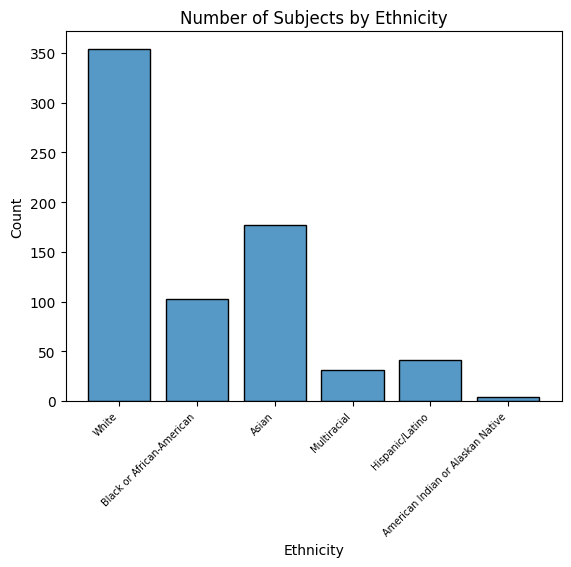

In [97]:
sns.histplot(data=train_df, x='Ethnicity', discrete=True, shrink=0.8)
plt.title('Number of Subjects by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.show()

In [98]:
r_1 = [col for col in train_df.columns if col.endswith('_1')]
r_2 = [col for col in train_df.columns if col.endswith('_2')]
r_3 = [col for col in train_df.columns if col.endswith('_3')]
r_4 = [col for col in train_df.columns if col.endswith('_4')]

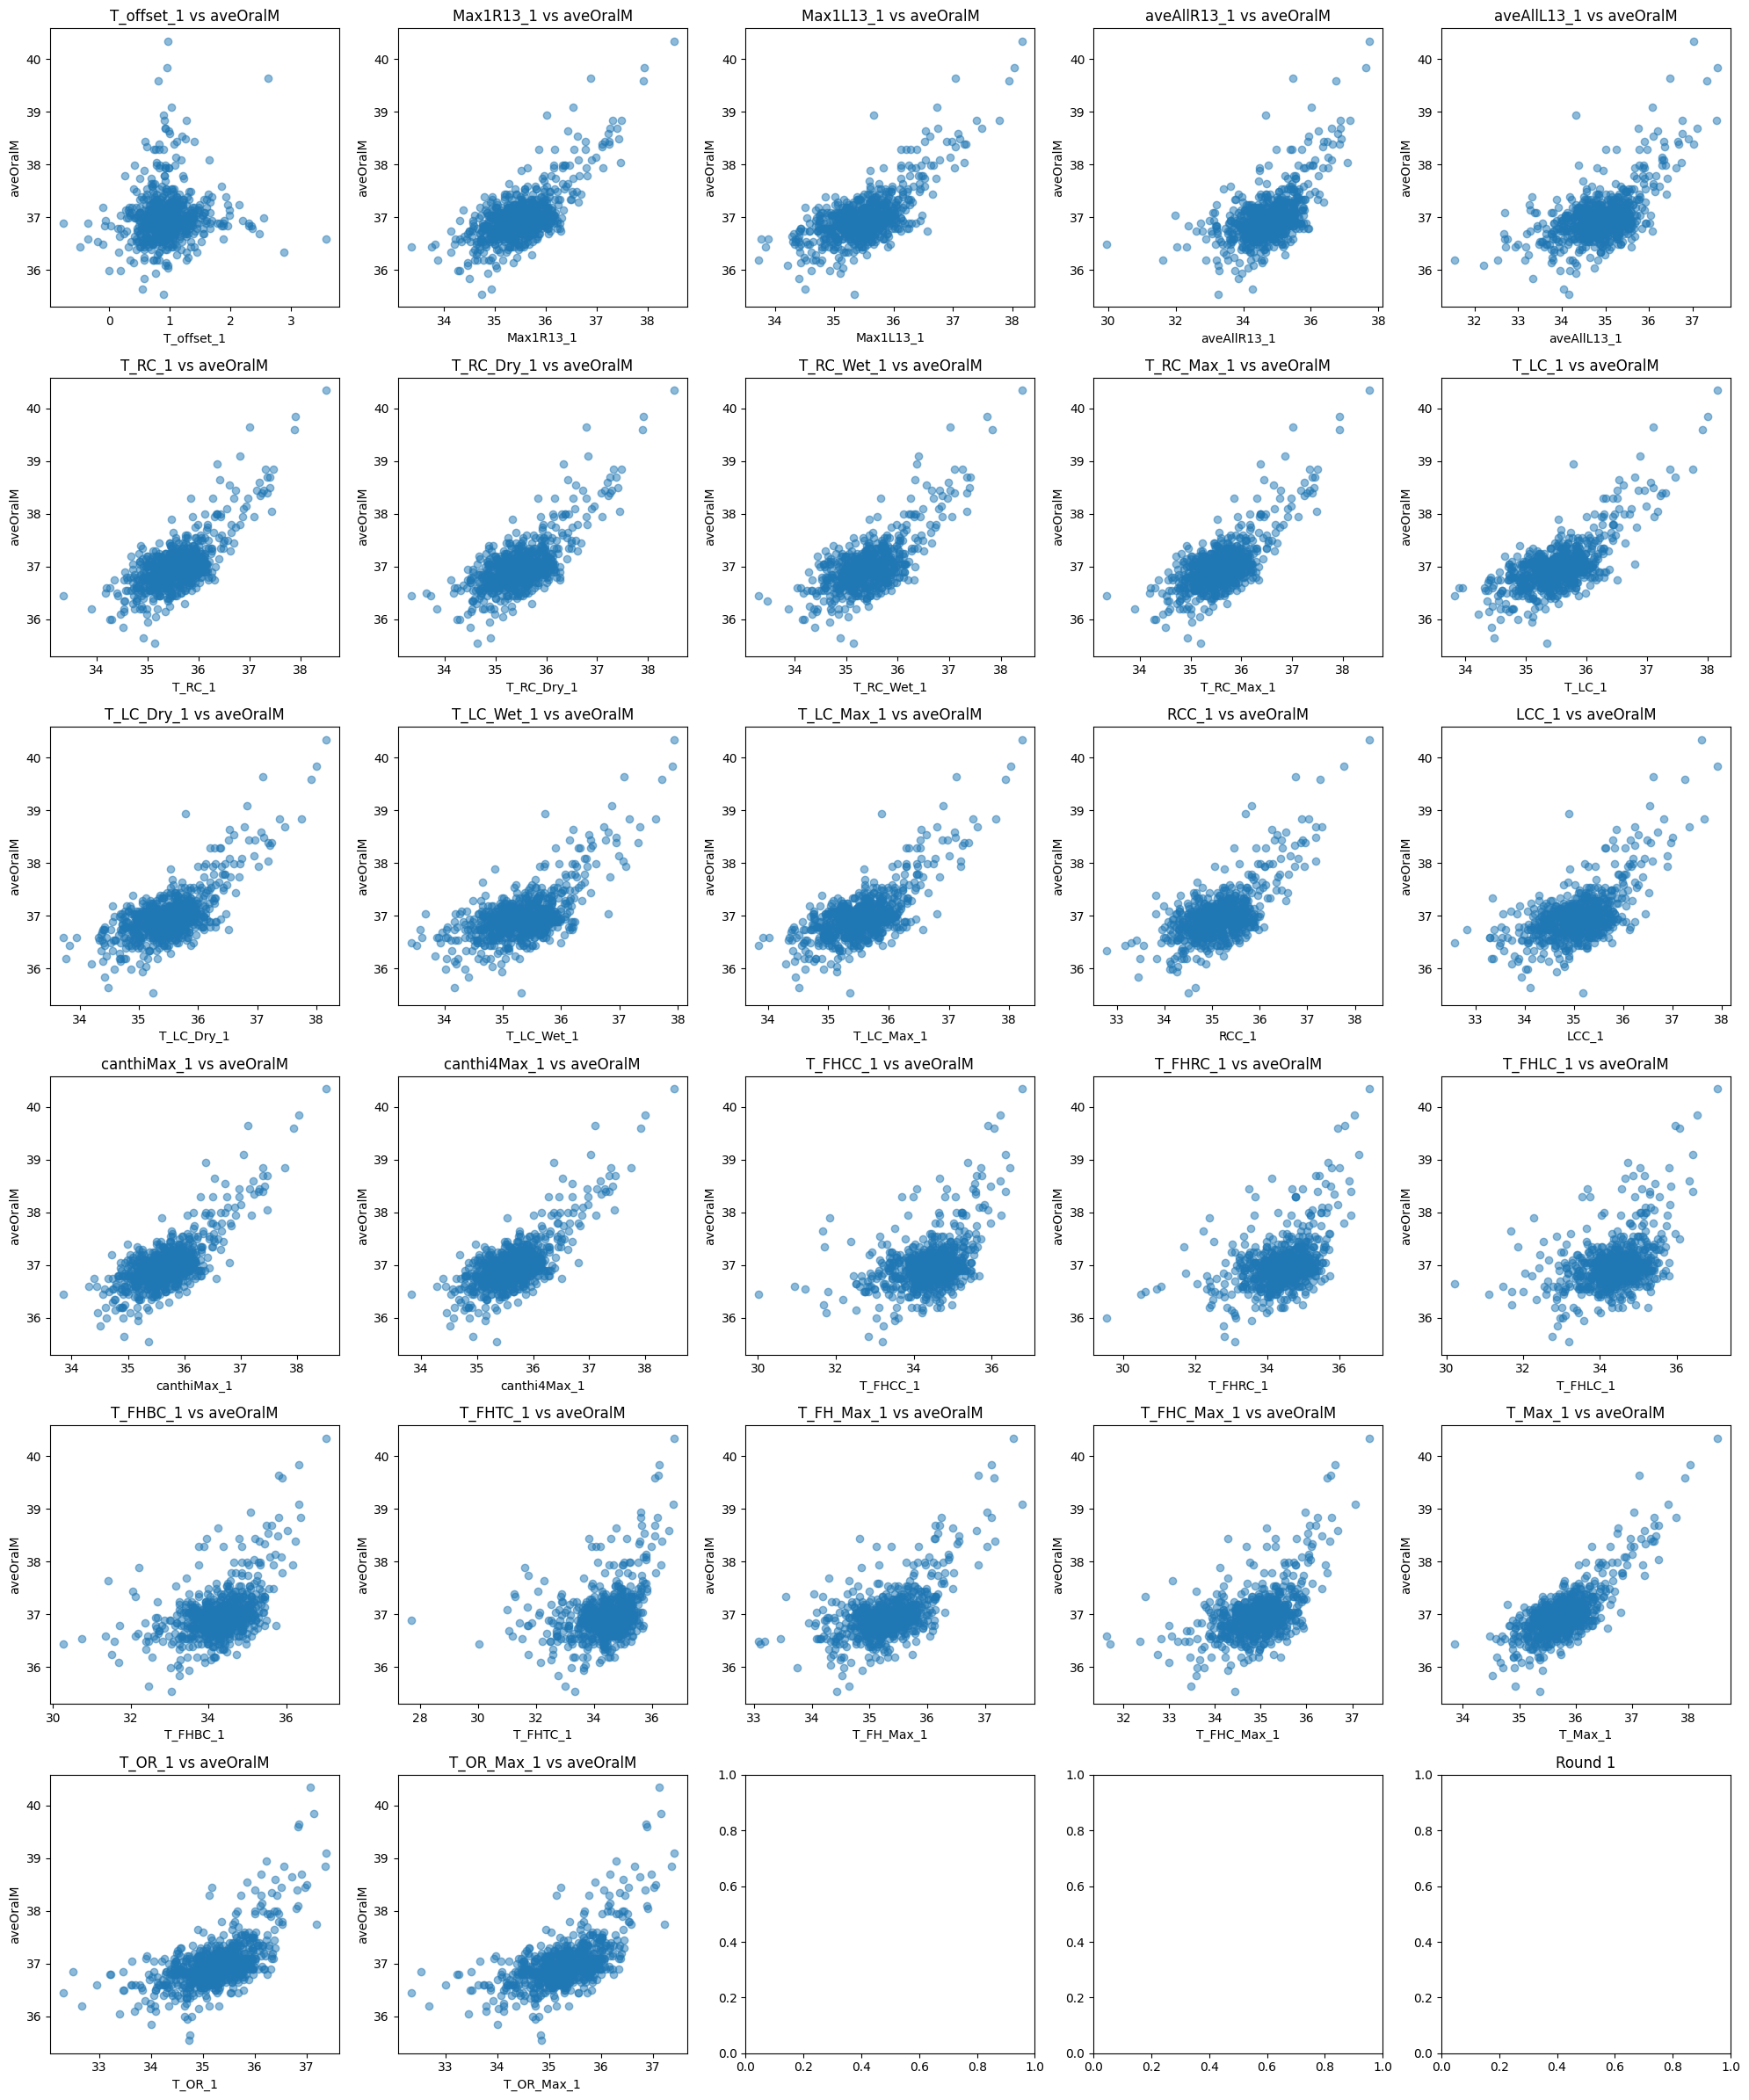

In [99]:
target_column = 'aveOralM'
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.flatten()

# Iterate through each column (except the target column)
for i, column in enumerate(train_df[r_1]):
    # Scatter plot between current column and target column
    axes[i].scatter(train_df[column], train_df[target_column], alpha=0.5)

    # Set labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)
    axes[i].set_title(f'{column} vs {target_column}')

plt.title('Round 1')
plt.tight_layout()
plt.show()

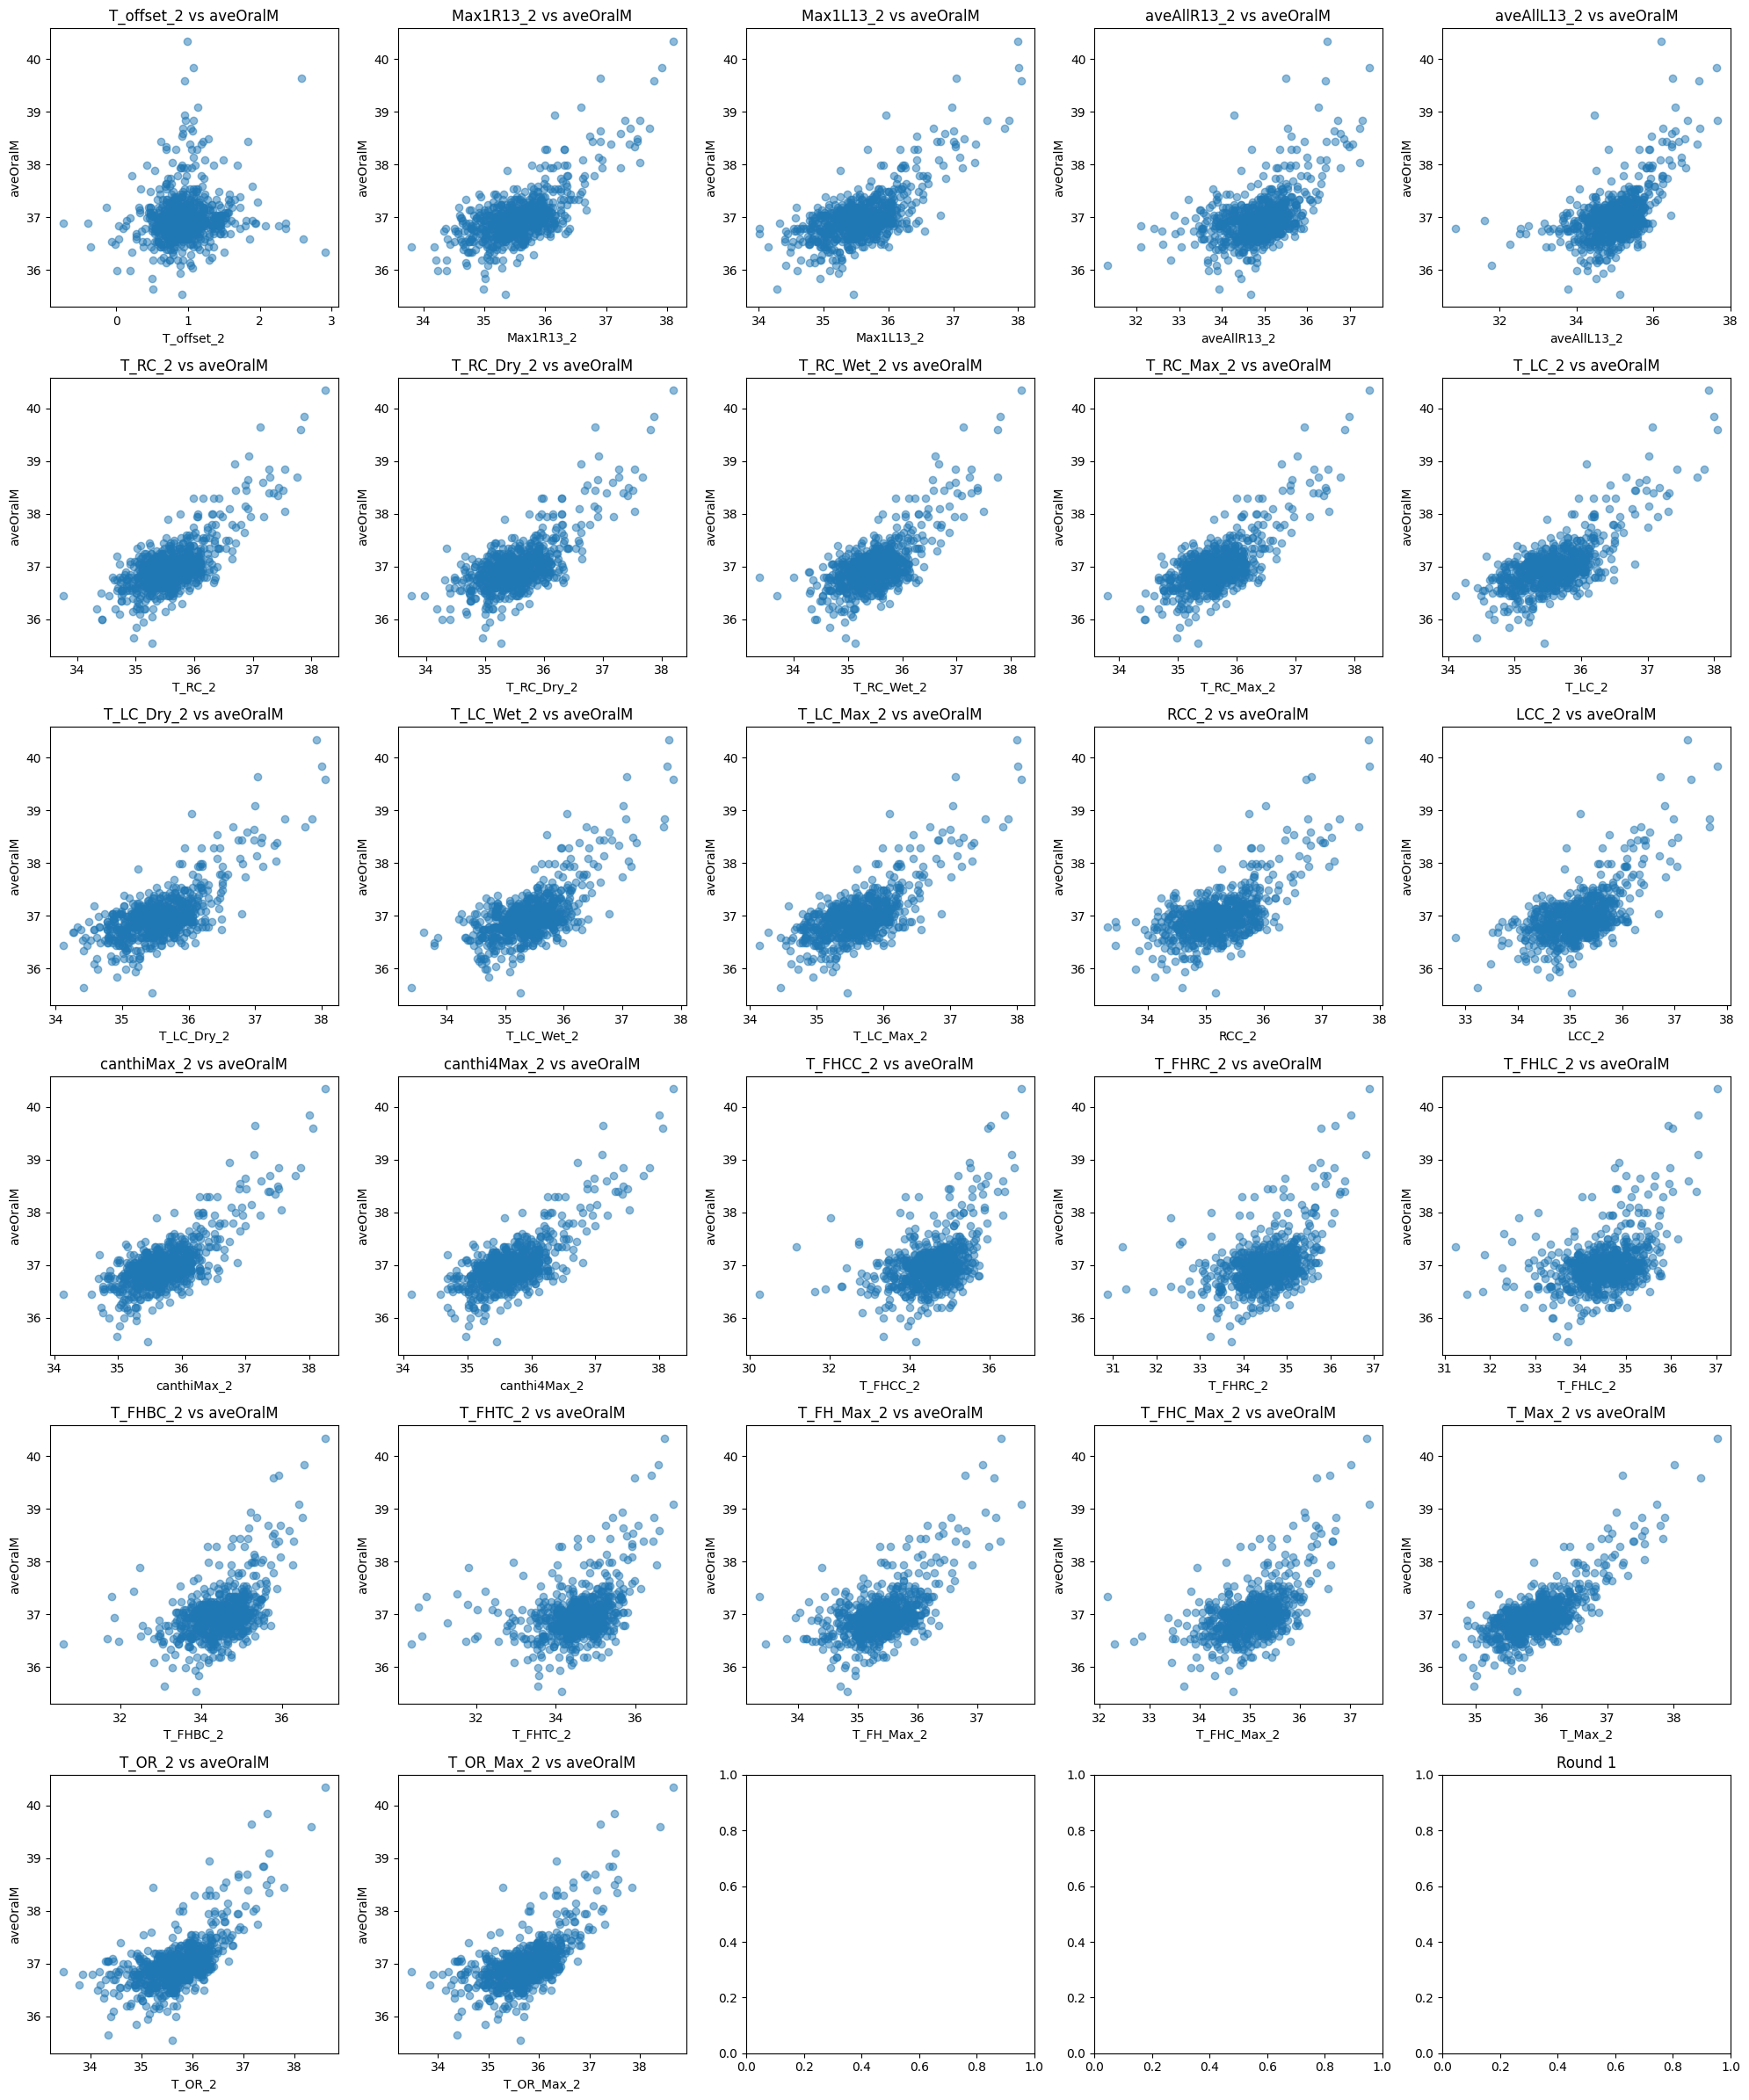

In [100]:
target_column = 'aveOralM'
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.flatten()

# Iterate through each column (except the target column)
for i, column in enumerate(train_df[r_2]):
    # Scatter plot between current column and target column
    axes[i].scatter(train_df[column], train_df[target_column], alpha=0.5)

    # Set labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)
    axes[i].set_title(f'{column} vs {target_column}')

plt.title('Round 1')
plt.tight_layout()
plt.show()

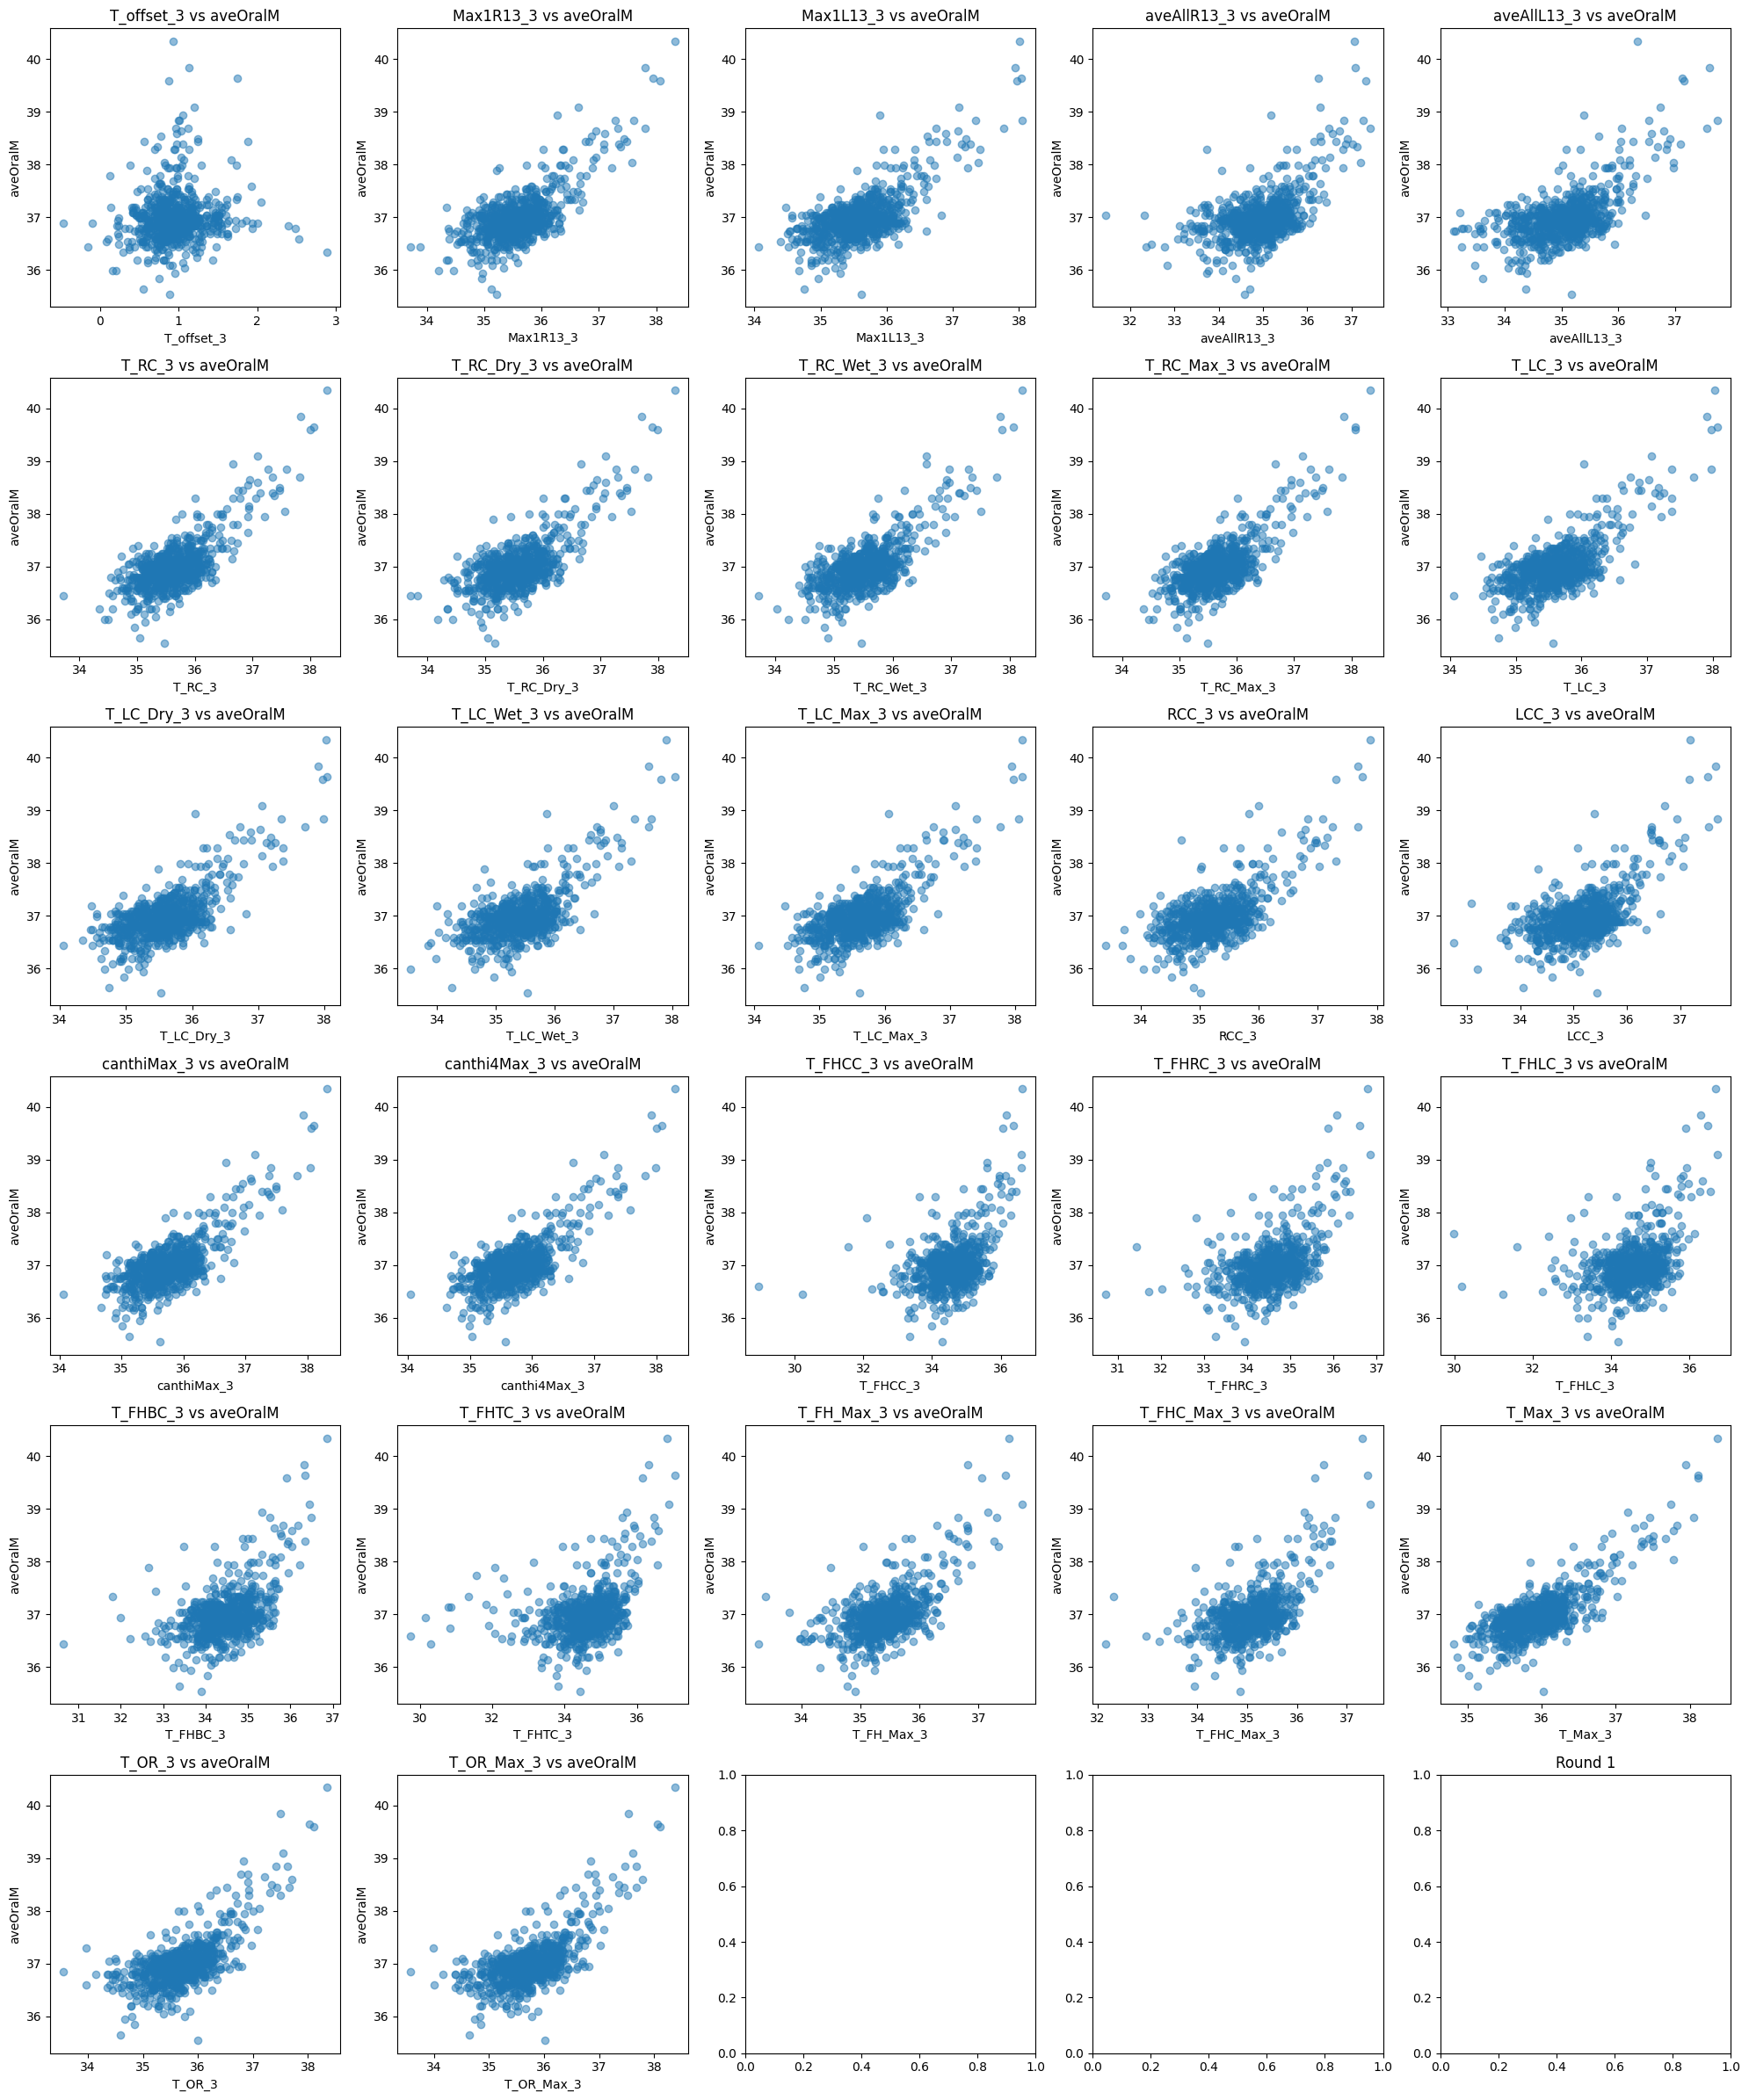

In [101]:
target_column = 'aveOralM'
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.flatten()

# Iterate through each column (except the target column)
for i, column in enumerate(train_df[r_3]):
    # Scatter plot between current column and target column
    axes[i].scatter(train_df[column], train_df[target_column], alpha=0.5)

    # Set labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)
    axes[i].set_title(f'{column} vs {target_column}')

plt.title('Round 1')
plt.tight_layout()
plt.show()

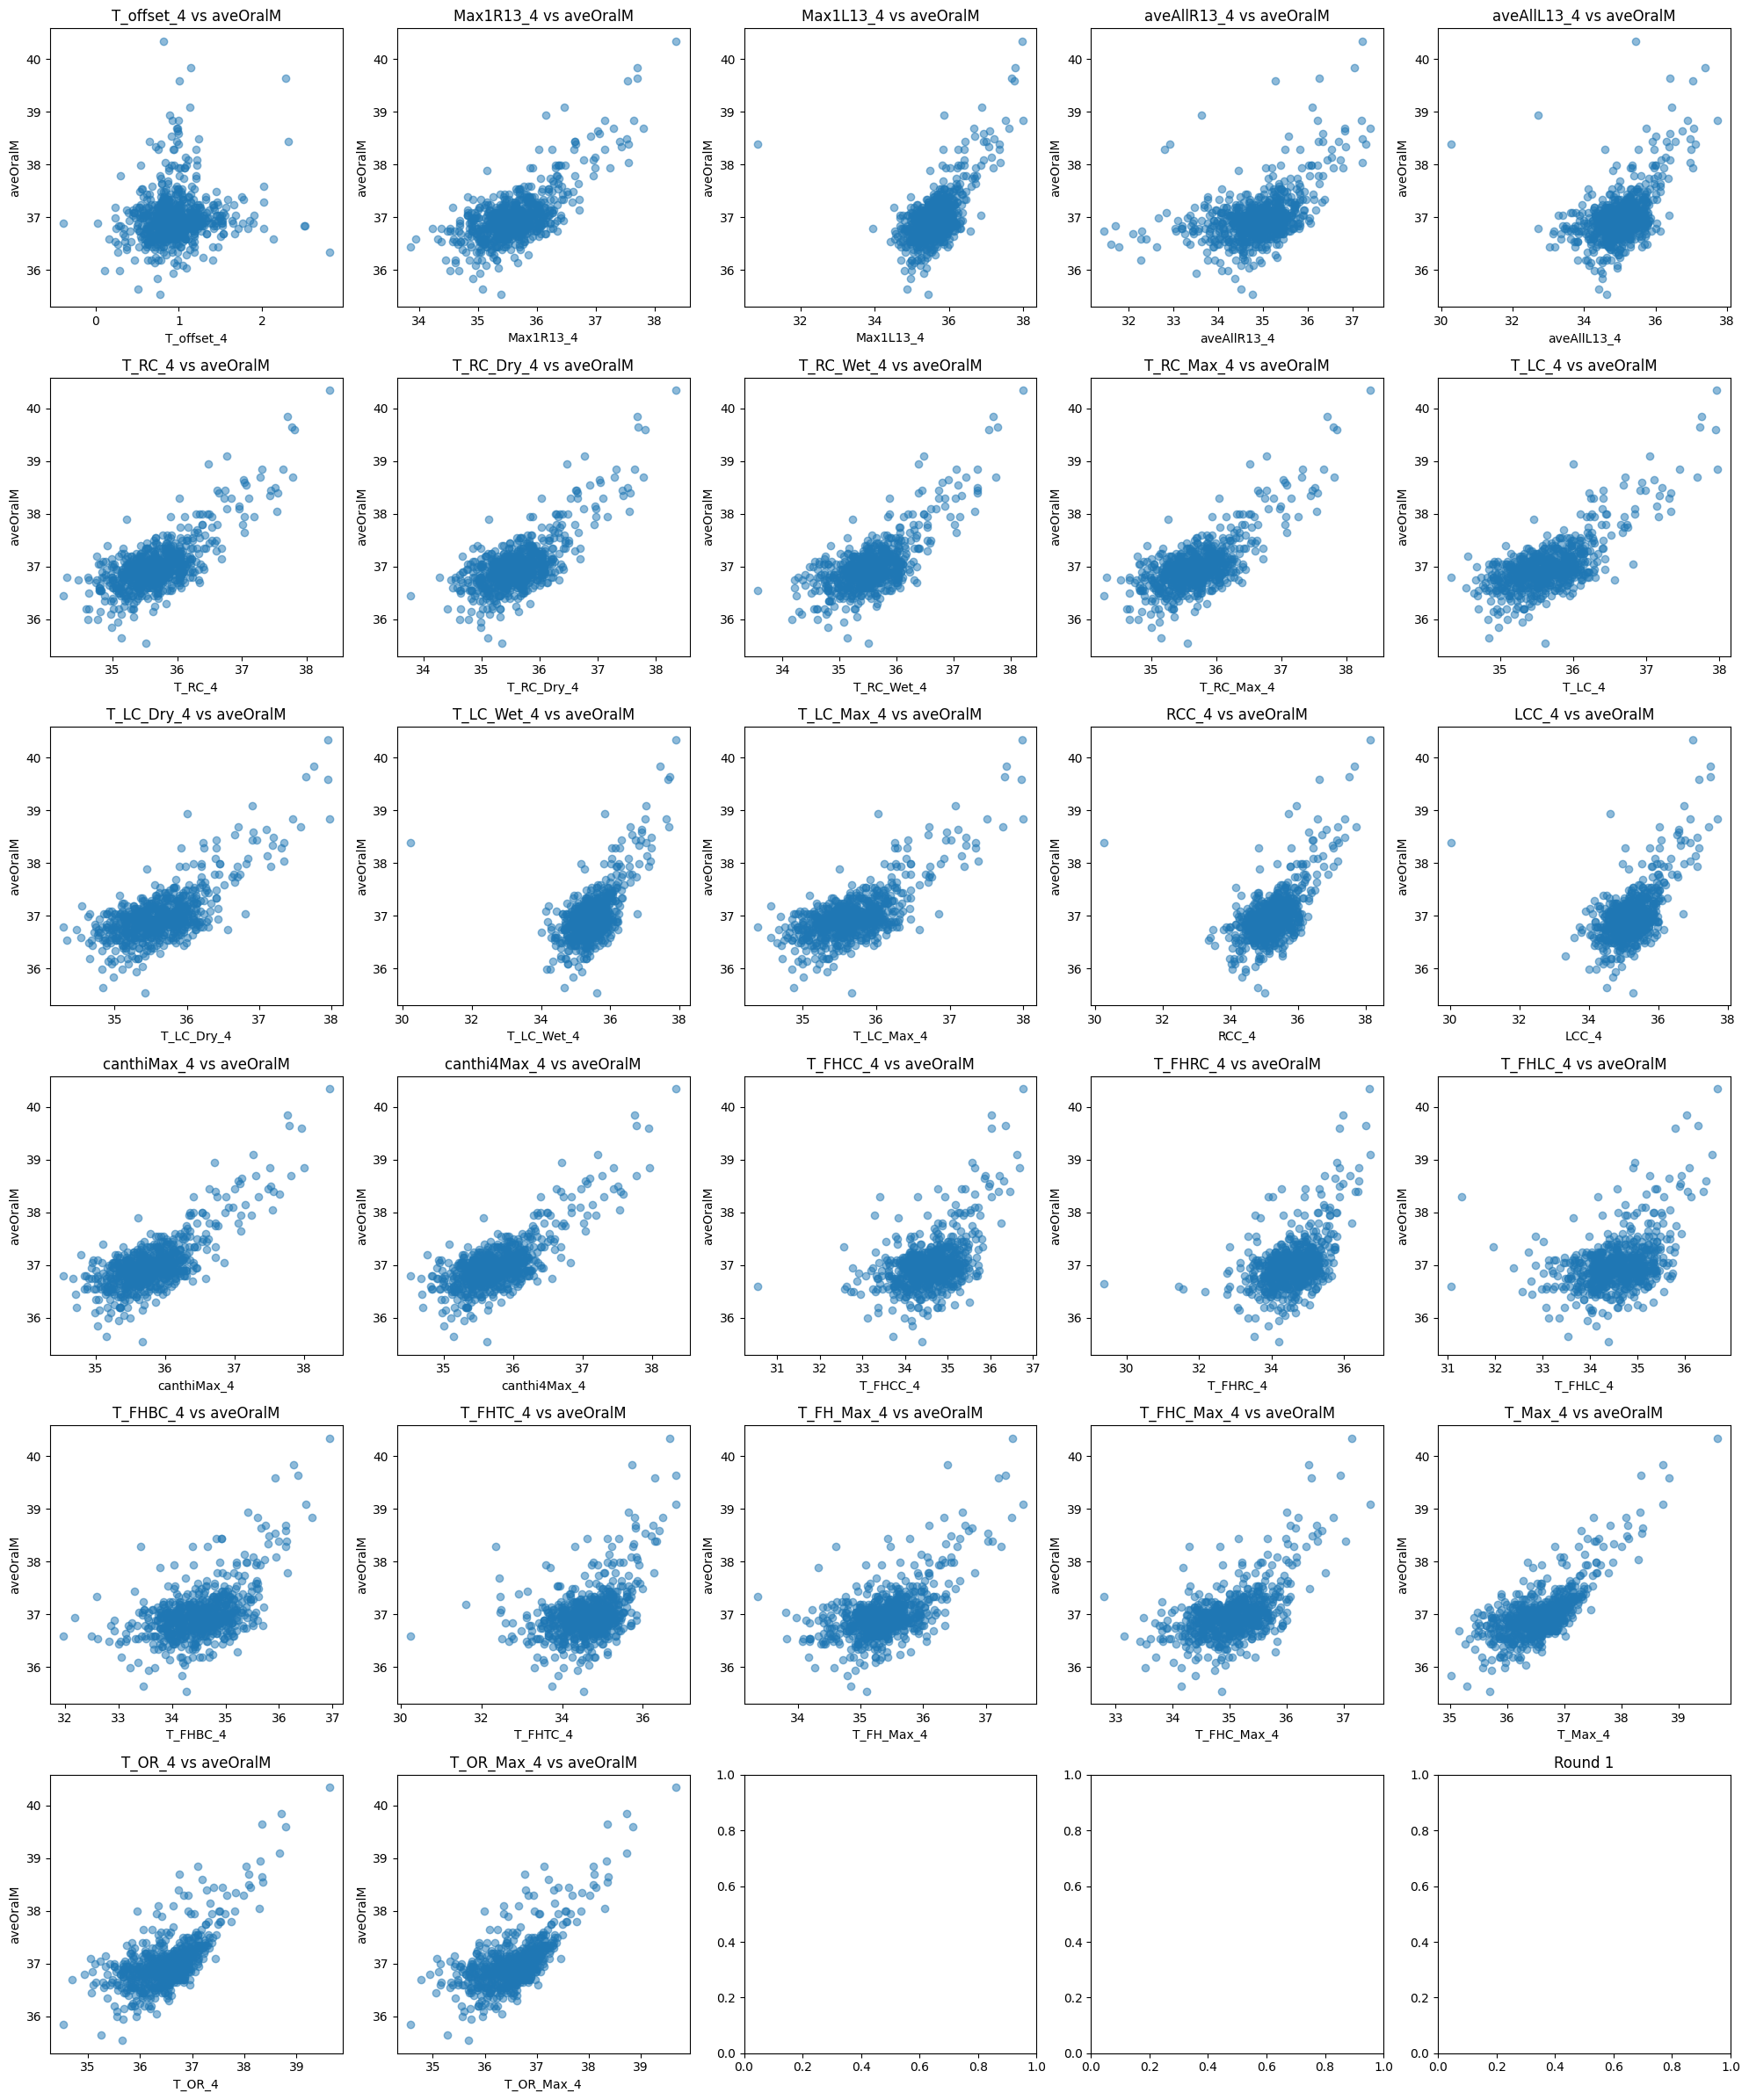

In [102]:
target_column = 'aveOralM'
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.flatten()

# Iterate through each column (except the target column)
for i, column in enumerate(train_df[r_4]):
    # Scatter plot between current column and target column
    axes[i].scatter(train_df[column], train_df[target_column], alpha=0.5)

    # Set labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)
    axes[i].set_title(f'{column} vs {target_column}')

plt.title('Round 1')
plt.tight_layout()
plt.show()

# Data Preprocessing - Train

In [103]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
gender_encoded = encoder.fit_transform(train_df[['Gender']])
train_df.drop('Gender', axis=1, inplace=True)
gender_encoded_df = pd.DataFrame(gender_encoded, index=train_df.index, columns=['Gender'])
train_df = pd.concat([train_df, gender_encoded_df], axis=1)

In [104]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

encoder = OneHotEncoder(sparse_output=False, categories=[['White', 'Black or African-American', 'Asian', 'Multiracial', 'Hispanic/Latino', 'American Indian or Alaskan Native']], handle_unknown='ignore')

ethnicity_mapping = {
    'White': 1,
    'Black or African-American': 2,
    'Asian': 3,
    'Multiracial': 4,
    'Hispanic/Latino': 5,
    'American Indian or Alaskan Native': 6

}

inverse_ethnicity_mapping = {v: k for k, v in ethnicity_mapping.items()}

if 'Ethnicity' in train_df.columns:
    ethnicity_encoded = encoder.fit_transform(train_df[['Ethnicity']])
    ethnicity_encoded_df = pd.DataFrame(ethnicity_encoded, columns=encoder.get_feature_names_out(['Ethnicity']))
    train_df.drop('Ethnicity', axis=1, inplace=True)
    train_df['Ethnicity'] = np.argmax(ethnicity_encoded, axis=1)


In [105]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')

if 'Age' in train_df.columns:
    age_reshaped = train_df['Age'].values.reshape(-1, 1)
    age_encoded = encoder.fit_transform(age_reshaped)
    train_df.drop('Age', axis=1, inplace=True)
    train_df['Age'] = np.argmax(age_encoded, axis=1) + 1

In [106]:
r = [1, 2, 3, 4]
for round_number in r:
    temperature_column = f'T_LC_{round_number}'

    if 'Gender' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            train_df[f'{temperature_column}_{stat.capitalize()}'] = train_df['Gender'].map(stat_dict)


In [107]:
for round_number in r:
    temperature_column = f'canthiMax_{round_number}'

    if 'Gender' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            train_df[f'{temperature_column}_{stat.capitalize()}'] = train_df['Gender'].map(stat_dict)

In [108]:
for round_number in r:
    temperature_column = f'T_FHC_Max_{round_number}'

    if 'Gender' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            train_df[f'{temperature_column}_{stat.capitalize()}'] = train_df['Gender'].map(stat_dict)

In [109]:
for round_number in r:
    temperature_column = f'T_FHCC_{round_number}'

    if 'Gender' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            train_df[f'{temperature_column}_{stat.capitalize()}'] = train_df['Gender'].map(stat_dict)

In [110]:
for round_number in r:
    temperature_column = f'canthiMax_{round_number}'

    if 'Ethnicity' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            train_df = pd.merge(train_df, temp_df, on='Ethnicity', how='left')


In [111]:
for round_number in r:
    temperature_column = f'T_LC_{round_number}'

    if 'Ethnicity' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            train_df = pd.merge(train_df, temp_df, on='Ethnicity', how='left')


In [112]:
for round_number in r:
    temperature_column = f'T_FHCC_{round_number}'

    if 'Ethnicity' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            train_df = pd.merge(train_df, temp_df, on='Ethnicity', how='left')


In [113]:
for round_number in r:
    temperature_column = f'T_FHC_Max_{round_number}'

    if 'Ethnicity' in train_df.columns and temperature_column in train_df.columns:
        grouped_stats = train_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            train_df = pd.merge(train_df, temp_df, on='Ethnicity', how='left')


In [114]:
from sklearn.preprocessing import StandardScaler

features = train_df.drop(columns=['aveOralM', 'SubjectID'])
target = train_df[['aveOralM', 'SubjectID']]
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)
train_df.loc[:, features.columns] = scaled_features

In [115]:
train_df.shape

(710, 244)

# Feature Engineering

In [116]:
import pandas as pd
import numpy as np

output_column = 'aveOralM'

if output_column in train_df.columns:
    correlation_matrix = train_df.corr(method='pearson', numeric_only=True)
    if output_column in correlation_matrix.columns:
        abs_correlation_with_output = correlation_matrix[output_column].abs().drop(output_column)
        psorted_features = abs_correlation_with_output.sort_values(ascending=False)

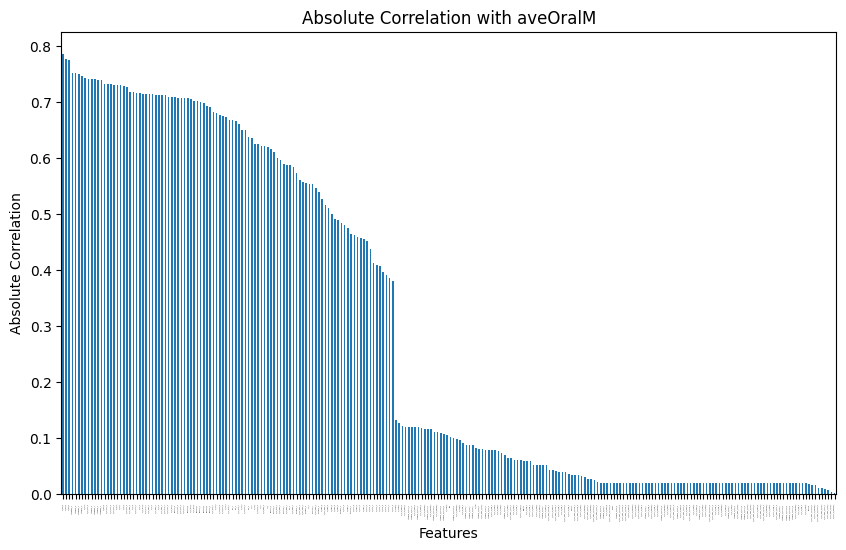

In [117]:
plt.figure(figsize=(10, 6))
psorted_features.plot(kind='bar')
plt.title('Absolute Correlation with {}'.format(output_column))
plt.xticks(range(len(psorted_features)), psorted_features.index, fontsize = 1)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()

In [118]:
pearson = psorted_features[psorted_features > 0.2]

In [119]:
pearson = pearson.index.tolist()

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

output_column = 'aveOralM'
feature_performance = {}

features = [col for col in train_df.columns if col not in [output_column, 'SubjectID']]

for feature in features:
    X = train_df[[feature]].values.reshape(-1, 1)
    y = train_df[output_column].values

    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    feature_performance[feature] = np.mean(scores)

top_features = sorted(feature_performance, key=feature_performance.get, reverse=True)

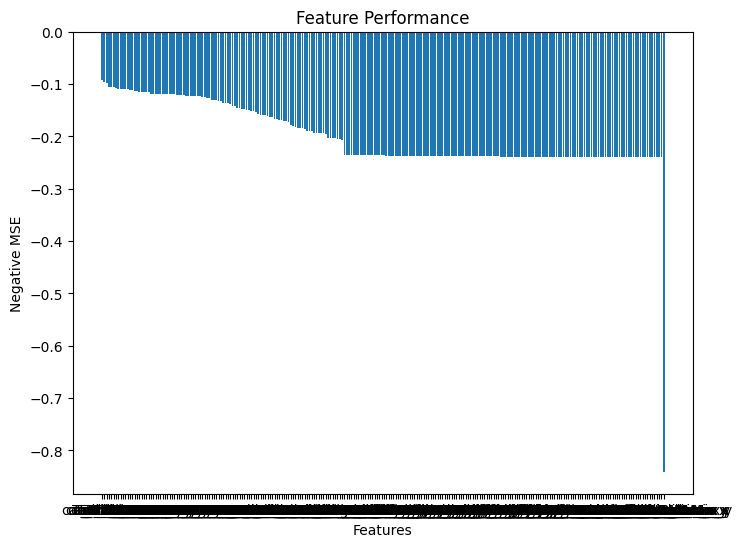

In [121]:
performance_scores = [feature_performance[feature] for feature in top_features]

plt.figure(figsize=(8, 6))
plt.bar(top_features, performance_scores)
plt.xlabel('Features')
plt.ylabel('Negative MSE')
plt.title('Feature Performance')
plt.show()

In [122]:
linear = [feature for feature in top_features if feature_performance[feature] > -0.21]

In [123]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

output_column = 'aveOralM'

X = train_df.select_dtypes(include=[np.number]).drop(columns=[output_column])
y = train_df[output_column]

model = LinearRegression()

sfs = SequentialFeatureSelector(model,
                                n_features_to_select=100,
                                direction='forward',
                                scoring='neg_mean_squared_error')

sfs.fit(X, y)
selected_features = X.columns[sfs.get_support()]

In [124]:
important_features = list(set(pearson) & set(linear) & set(selected_features))

In [125]:
len(important_features)

46

In [126]:
# important_features = ['T_RC_Wet_3',
#  'T_FHC_Max_2',
#  'RCC_2',
#  'T_FH_Max_3',
#  'T_RC_3',
#  'T_FHBC_4',
#  'T_RC_Max_1',
#  'T_RC_Dry_1',
#  'T_FHLC_2',
#  'T_FHLC_4',
#  'T_Max_1',
#  'Max1R13_2',
#  'T_RC_Max_4',
#  'T_OR_Max_1',
#  'T_FHTC_2',
#  'T_LC_1',
#  'canthi4Max_2',
#  'aveAllL13_2',
#  'T_OR_1',
#  'canthiMax_1',
#  'T_FHTC_1',
#  'T_RC_4',
#  'T_RC_Dry_3',
#  'RCC_1',
#  'Max1L13_1',
#  'T_FHC_Max_4',
#  'LCC_4',
#  'T_LC_Dry_1',
#  'T_FH_Max_2',
#  'T_LC_Dry_2',
#  'T_Max_4',
#  'RCC_3',
#  'T_RC_Wet_1',
#  'T_FHCC_2',
#  'T_LC_Max_1',
#  'LCC_2',
#  'T_OR_4',
#  'T_RC_Max_2',
#  'Max1R13_1',
#  'aveAllR13_2',
#  'T_FHLC_3',
#  'T_OR_Max_4',
#  'T_Max_3',
#  'aveAllR13_3',
#  'Max1L13_3',
#  'aveAllR13_1']

['T_RC_Wet_3',
 'T_FHC_Max_2',
 'RCC_2',
 'T_FH_Max_3',
 'T_RC_3',
 'T_FHBC_4',
 'T_RC_Max_1',
 'T_RC_Dry_1',
 'T_FHLC_2',
 'T_FHLC_4',
 'T_Max_1',
 'Max1R13_2',
 'T_RC_Max_4',
 'T_OR_Max_1',
 'T_FHTC_2',
 'T_LC_1',
 'canthi4Max_2',
 'aveAllL13_2',
 'T_OR_1',
 'canthiMax_1',
 'T_FHTC_1',
 'T_RC_4',
 'T_RC_Dry_3',
 'RCC_1',
 'Max1L13_1',
 'T_FHC_Max_4',
 'LCC_4',
 'T_LC_Dry_1',
 'T_FH_Max_2',
 'T_LC_Dry_2',
 'T_Max_4',
 'RCC_3',
 'T_RC_Wet_1',
 'T_FHCC_2',
 'T_LC_Max_1',
 'LCC_2',
 'T_OR_4',
 'T_RC_Max_2',
 'Max1R13_1',
 'aveAllR13_2',
 'T_FHLC_3',
 'T_OR_Max_4',
 'T_Max_3',
 'aveAllR13_3',
 'Max1L13_3',
 'aveAllR13_1']

# Data Preprocessing - Test

In [127]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
gender_encoded = encoder.fit_transform(test_df[['Gender']])
test_df.drop('Gender', axis=1, inplace=True)
gender_encoded_df = pd.DataFrame(gender_encoded, index=test_df.index, columns=['Gender'])
test_df = pd.concat([test_df, gender_encoded_df], axis=1)

In [128]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np


encoder = OneHotEncoder(sparse_output=False, categories=[['White', 'Black or African-American', 'Asian', 'Multiracial', 'Hispanic/Latino', 'American Indian or Alaskan Native']], handle_unknown='ignore')

ethnicity_mapping = {
    'White': 1,
    'Black or African-American': 2,
    'Asian': 3,
    'Multiracial': 4,
    'Hispanic/Latino': 5,
    'American Indian or Alaskan Native': 6

}


inverse_ethnicity_mapping = {v: k for k, v in ethnicity_mapping.items()}

if 'Ethnicity' in test_df.columns:
    ethnicity_encoded = encoder.fit_transform(test_df[['Ethnicity']])
    ethnicity_encoded_df = pd.DataFrame(ethnicity_encoded, columns=encoder.get_feature_names_out(['Ethnicity']))
    test_df.drop('Ethnicity', axis=1, inplace=True)
    test_df['Ethnicity'] = np.argmax(ethnicity_encoded, axis=1)


In [129]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')

if 'Age' in test_df.columns:
    age_reshaped = test_df['Age'].values.reshape(-1, 1)
    age_encoded = encoder.fit_transform(age_reshaped)
    test_df.drop('Age', axis=1, inplace=True)
    test_df['Age'] = np.argmax(age_encoded, axis=1) + 1


In [130]:
r = [1, 2, 3, 4]
for round_number in r:
    temperature_column = f'T_LC_{round_number}'

    if 'Gender' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            test_df[f'{temperature_column}_{stat.capitalize()}'] = test_df['Gender'].map(stat_dict)


In [131]:
for round_number in r:
    temperature_column = f'canthiMax_{round_number}'

    if 'Gender' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            test_df[f'{temperature_column}_{stat.capitalize()}'] = test_df['Gender'].map(stat_dict)


In [132]:
for round_number in r:
    temperature_column = f'T_FHC_Max_{round_number}'

    if 'Gender' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            test_df[f'{temperature_column}_{stat.capitalize()}'] = test_df['Gender'].map(stat_dict)


In [133]:
for round_number in r:
    temperature_column = f'T_FHCC_{round_number}'

    if 'Gender' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Gender')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        for stat in ['mean', 'min', 'max', 'median']:
            stat_dict = dict(zip(grouped_stats['Gender'], grouped_stats[stat]))
            test_df[f'{temperature_column}_{stat.capitalize()}'] = test_df['Gender'].map(stat_dict)


In [134]:
for round_number in r:
    temperature_column = f'canthiMax_{round_number}'

    if 'Ethnicity' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            test_df = pd.merge(test_df, temp_df, on='Ethnicity', how='left')


In [135]:
for round_number in r:
    temperature_column = f'T_LC_{round_number}'

    if 'Ethnicity' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            test_df = pd.merge(test_df, temp_df, on='Ethnicity', how='left')


In [136]:
for round_number in r:
    temperature_column = f'T_FHCC_{round_number}'

    if 'Ethnicity' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            test_df = pd.merge(test_df, temp_df, on='Ethnicity', how='left')


In [137]:
for round_number in r:
    temperature_column = f'T_FHC_Max_{round_number}'

    if 'Ethnicity' in test_df.columns and temperature_column in test_df.columns:
        grouped_stats = test_df.groupby('Ethnicity')[temperature_column].agg(['mean', 'min', 'max', 'median']).reset_index()
        rename_stats = {stat: f'{temperature_column}_{stat.capitalize()}' for stat in ['mean', 'min', 'max', 'median']}
        grouped_stats = grouped_stats.rename(columns=rename_stats)
        for stat in ['mean', 'min', 'max', 'median']:
            new_col_name = f'{temperature_column}_{stat.capitalize()}'
            temp_df = grouped_stats[['Ethnicity', new_col_name]]
            test_df = pd.merge(test_df, temp_df, on='Ethnicity', how='left')


In [138]:
from sklearn.preprocessing import StandardScaler

test_features = test_df.drop(columns=['aveOralM', 'SubjectID'])
test_target = test_df[['aveOralM', 'SubjectID']]

scaled_test_features = scaler.transform(test_features)
test_df.loc[:, test_features.columns] = scaled_test_features


# Model - Linear Regression

In [156]:
columns = ['SubjectID'] + important_features + ['aveOralM']
train_df = train_df[columns]
test_df = test_df[columns]

In [157]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

X = train_df.drop(columns=['SubjectID', 'aveOralM'])
y = train_df['aveOralM']
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LinearRegression()

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))


In [158]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.24167163320165846
Avg Train MAE:  0.18995423619416046

Avg Val RMSE:  0.26636404683500875
Avg Val MAE:  0.20992091147762154


In [159]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.08108658004550752
Test RMSE:  0.2847570544262381
Test MAE:  0.21830305318740478
Test R^2:  0.7319615330383954


# Model - Trivial System

In [160]:
class TrivialSystem:
    def __init__(self):
        self.mean_value = None

    def fit(self, X_train, y_train):
        self.mean_value = y_train.mean()

    def predict(self, input_data):
        return [self.mean_value] * len(input_data)

In [161]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = TrivialSystem()

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))


In [162]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.48723527683216333
Avg Train MAE:  0.3158600104146005

Avg Val RMSE:  0.48392436467292493
Avg Val MAE:  0.31609254116246815


In [163]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.3118289187433221
Test RMSE:  0.5584164384608695
Test MAE:  0.35304179918218886
Test R^2:  -0.03077655127823542


# Model - 1NN

In [164]:
from sklearn.neighbors import KNeighborsRegressor

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = KNeighborsRegressor(n_neighbors=1)

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))




In [165]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.0
Avg Train MAE:  0.0

Avg Val RMSE:  0.3553499824072294
Avg Val MAE:  0.26838028169014094


In [166]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.13015322580645197
Test RMSE:  0.3607675509333565
Test MAE:  0.2788709677419358
Test R^2:  0.5697676348454932


# Model - SVR - Linear

In [192]:
from sklearn.svm import SVR

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = SVR(kernel='linear')

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))


In [193]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.24594255241933957
Avg Train MAE:  0.18814144801270766

Avg Val RMSE:  0.2682838104751876
Avg Val MAE:  0.20841615349369125


In [194]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.08298107085910962
Test RMSE:  0.28806435194086344
Test MAE:  0.2189439998895466
Test R^2:  0.7256991353263971


# Model - SVR - RBF

In [188]:
from sklearn.svm import SVR

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = SVR(kernel='rbf')

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))


In [189]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.18592502912892056
Avg Train MAE:  0.13765346910933066

Avg Val RMSE:  0.28613369405849837
Avg Val MAE:  0.20954371516551693


In [190]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.07096159785313469
Test RMSE:  0.2663861817984084
Test MAE:  0.20006991690256373
Test R^2:  0.7654305078469774


# Model - Polynomial Regression

In [170]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = pd.DataFrame(poly.fit_transform(X))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LinearRegression()

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X_poly):
    X_train_fold, X_val_fold = X_poly.iloc[train_index], X_poly.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))

In [171]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  1.1180819583730243e-14
Avg Train MAE:  8.028632531880851e-15

Avg Val RMSE:  0.9156242459585828
Avg Val MAE:  0.5835490583982166


In [172]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

Y_poly = pd.DataFrame(poly.fit_transform(X_test))

y_pred = model.predict(Y_poly)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  1.154523522165064
Test RMSE:  1.0744875625920778
Test MAE:  0.6125640785492577
Test R^2:  -2.8163739891183246


# Model - Non- Linear Transformation through RBF and Regression

In [173]:
def cal_gamma(M):
  g = M / 32
  return g

def rbf_kernel(x, mu, gamma):
    return np.exp(-gamma * np.linalg.norm(x - mu)**2)

def Linear_Reg(X_train_transformed, y_train):
    model = LinearRegression()
    model.fit(X_train_transformed, y_train)
    return model

In [176]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

def cross_validation_with_kmeans(X, y, K_values, gammas, n_folds=5):
    best_gamma = None
    best_K = None
    best_rmse = float('inf')
    kf = KFold(n_splits=n_folds)

    for K in K_values:
        best_rmse_K = float('inf')
        for gamma in gammas:
            g_d = 0
            fold_rmse = []
            fold_rmse1 = []
            fold_mae = []
            fold_mae1 = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                kmeans = KMeans(n_clusters=K, init='random')
                kmeans.fit(X_train)
                centers = kmeans.cluster_centers_

                if g_d == 0:
                  gamma = (K**0.06)/32 * gamma
                  g_d += 1

                X_train_transformed = np.array([[rbf_kernel(x, mu, gamma) for mu in centers] for x in X_train.values])
                X_val_transformed = np.array([[rbf_kernel(x, mu, gamma) for mu in centers] for x in X_val.values])

                model = Linear_Reg(X_train_transformed, y_train)
                y_pred_val = model.predict(X_val_transformed)
                y_pred_train = model.predict(X_train_transformed)

                rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
                rmse1 = np.sqrt(mean_squared_error(y_train, y_pred_train))

                mae =  mean_absolute_error(y_val, y_pred_val)
                mae1 = mean_absolute_error(y_train, y_pred_train)


                fold_rmse.append(rmse)
                fold_rmse1.append(rmse1)

                fold_mae.append(mae)
                fold_mae1.append(mae1)

            avg_rmse = np.mean(fold_rmse)
            avg_rmse1 = np.mean(fold_rmse1)
            avg_mae = np.mean(fold_mae)
            avg_mae1 = np.mean(fold_mae1)

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                b = avg_rmse1
                c = avg_mae
                d = avg_mae1
                best_gamma = gamma
                best_K = K

    return best_K, best_gamma, best_rmse, b, c, d

In [177]:
gammas = [0.01, 0.1, 1, 10]
K = range(5, 101, 5)
best_K, best_gamma, val_rmse, train_rmse, val_mae, train_mae = cross_validation_with_kmeans(X, y, K, gammas)

In [178]:
print(val_rmse, train_rmse, val_mae, train_mae)

0.2455577621631694 0.22716249583690837 0.18979053552825034 0.176237003616801


In [179]:
print(best_K, best_gamma, )

35 0.00038680680359592354


In [180]:
X_train = X
y_train = y

kmeans = KMeans(n_clusters=best_K, init='random')
kmeans.fit(X_train)
centers = kmeans.cluster_centers_

X_train_transformed = np.array([[rbf_kernel(x, mu, best_gamma) for mu in centers] for x in X_train.values])
model3 = Linear_Reg(X_train_transformed, y_train)

X_test_transformed = np.array([[rbf_kernel(x, mu, best_gamma) for mu in centers] for x in X_test.values])

y_pred = model3.predict(X_test_transformed)
print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.0693928270439455
Test RMSE:  0.2634251830101775
Test MAE:  0.1980927482368411
Test R^2:  0.7706162108631016


# Model - Random Forest Regressor + Hyperparameter Tuning

In [181]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

param_dist = {
    'n_estimators': np.random.randint(50, 1000, size=100),
    'max_depth': np.random.randint(3, 15, size=100),
    'min_samples_split': np.random.randint(2, 20, size=100),
    'min_samples_leaf': np.random.randint(1, 10, size=100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42)

random_search.fit(X, y)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Best Hyperparameters: {'n_estimators': 581, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}
Best Score: 0.06777555033586269


In [182]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
best_params = random_search.best_params_
model = RandomForestRegressor(**best_params)

train_rmse_scores = []
val_rmse_scores = []

train_mae_scores = []
val_mae_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict(X_train_fold)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train_fold, y_pred_train)))
    train_mae_scores.append(mean_absolute_error(y_train_fold, y_pred_train))

    y_pred_val = model.predict(X_val_fold)
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
    val_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))

In [183]:
print("Avg Train RMSE: ", np.mean(train_rmse_scores))
print("Avg Train MAE: ", np.mean(train_mae_scores))

print("\nAvg Val RMSE: ", np.mean(val_rmse_scores))
print("Avg Val MAE: ", np.mean(val_mae_scores))

Avg Train RMSE:  0.13857839867365346
Avg Train MAE:  0.11023061949018846

Avg Val RMSE:  0.2564860050831878
Avg Val MAE:  0.195082741026605


In [184]:
from sklearn.metrics import r2_score, mean_absolute_error

X_test = test_df.drop(columns=['SubjectID', 'aveOralM'])
y_test = test_df['aveOralM']

y_pred = model.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_pred))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print("Test R^2: ", r2_score(y_test, y_pred))

Test MSE:  0.059288927296631655
Test RMSE:  0.24349317710488658
Test MAE:  0.1851068243180197
Test R^2:  0.8040154958876251


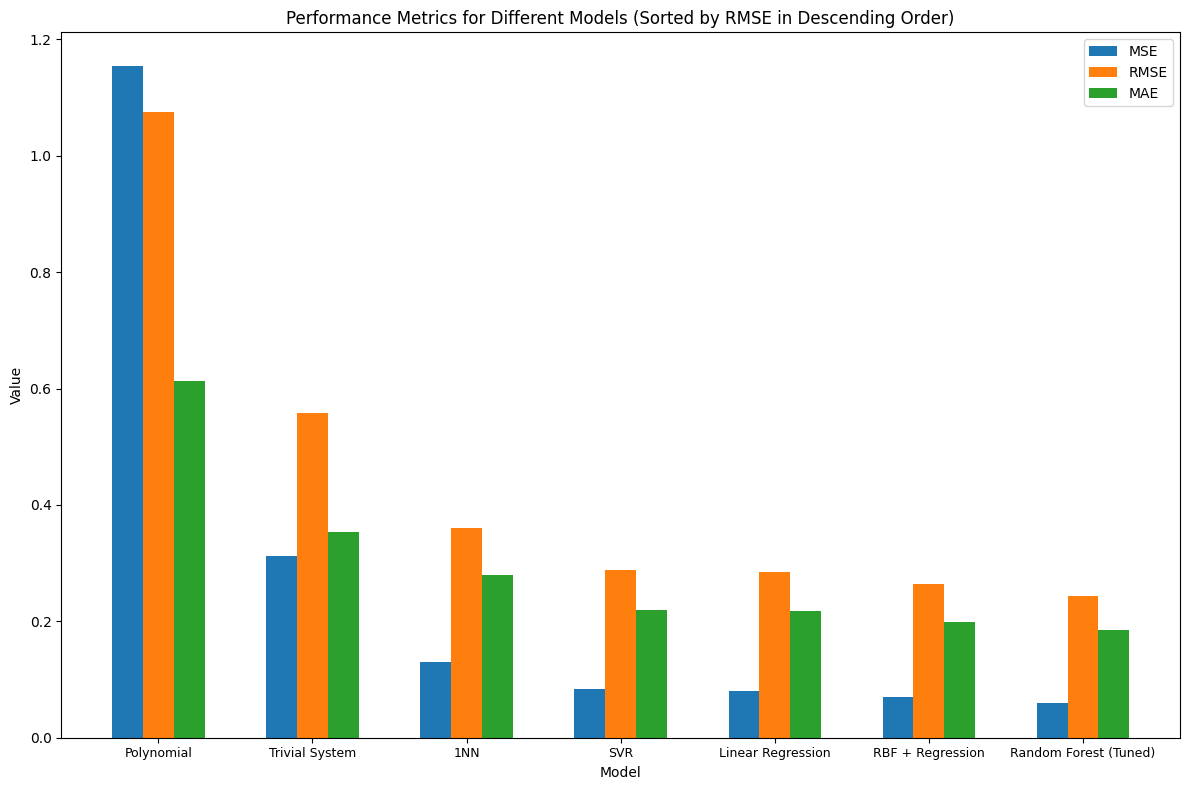

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their corresponding performance metrics
models = ["Linear Regression", "Trivial System", "1NN", "SVR", "Polynomial", "RBF + Regression", "Random Forest (Tuned)"]
mse_values = [0.08108658004550752, 0.3118289187433221, 0.13015322580645197, 0.08298107085910962, 1.154523522165064, 0.0693928270439455, 0.059288927296631655]
rmse_values = [0.2847570544262381, 0.5584164384608695, 0.3607675509333565, 0.28806435194086344, 1.0744875625920778, 0.2634251830101775, 0.24349317710488658]
mae_values = [0.21830305318740478, 0.35304179918218886, 0.2788709677419358, 0.2189439998895466, 0.6125640785492577, 0.1980927482368411, 0.1851068243180197]

# Sort the models based on their RMSE values in descending order
sorted_indices = np.argsort(rmse_values)[::-1]
sorted_models = [models[i] for i in sorted_indices]
sorted_mse = [mse_values[i] for i in sorted_indices]
sorted_rmse = [rmse_values[i] for i in sorted_indices]
sorted_mae = [mae_values[i] for i in sorted_indices]

# Set the width of the bars
bar_width = 0.2
index = np.arange(len(models))

# Create grouped bar plots
plt.figure(figsize=(12, 8))
plt.bar(index - bar_width, sorted_mse, bar_width, label='MSE')
plt.bar(index, sorted_rmse, bar_width, label='RMSE')
plt.bar(index + bar_width, sorted_mae, bar_width, label='MAE')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Performance Metrics for Different Models (Sorted by RMSE in Descending Order)')
plt.xticks(index, sorted_models, fontsize=9)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
